# Bayesian MBG Predictions (batched)

In [16]:
import pymc as pm
#import aesara.tensor as at
#from aesara.graph.basic import Constant
import os
import pickle
import numpy as np
import arviz as az
import pandas as pd


import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.preprocessing import StandardScaler
import pytensor.tensor as at

import uuid

import pytensor.tensor as at

## Geostatistical Modeling

### Parameters

In [3]:
#Define the directory where the pickle files are stored
pickle_dir = 'temp_files'

target_indicator = 'mpi'

# Get the number of CPU cores to max out the machine in the traning stage
num_cores = os.cpu_count()

print(f"Number of CPU cores: {num_cores}")

Number of CPU cores: 8


### Load target and covariates

In [4]:
df = pd.read_pickle('temp_files/selected_features.pkl')

In [5]:
selected_features = df.columns.to_list()

# Remove target_values and others
remove_list = [target_indicator, 'geometry', 'grid_id']

# Remove elements in remove_list from main_list
selected_features = [item for item in selected_features if item not in remove_list]

In [6]:
# Load coordinates from the pickle file
with open(os.path.join(pickle_dir, 'coordinates.pkl'), 'rb') as f:
    coordinates = pickle.load(f)

# Load coordinates for observed rows from the pickle file
with open(os.path.join(pickle_dir, 'coordinates_observed.pkl'), 'rb') as f:
    coordinates_observed = pickle.load(f)

In [7]:
df = pd.read_pickle('temp_files/selected_features.pkl')

In [8]:
selected_features = df.columns.to_list()

# Remove target_values and others
remove_list = [target_indicator, 'geometry', 'grid_id']

# Remove elements in remove_list from main_list
selected_features = [item for item in selected_features if item not in remove_list]

In [9]:
#Only rows with observed target indicator
df1 = df[~df[target_indicator].isnull()]

In [10]:
df1.shape

(434, 11)

In [11]:
# Covariate matrix
X = df1[selected_features].values

# Series with the target variable observed
response = df1[target_indicator].values

In [12]:
# Standardize features and response
X = (X - X.mean(axis=0)) / X.std(axis=0)
response = (response - response.mean()) / response.std()

### Recreate the saved model

In [13]:
# After fitting the model
trace_filename = 'model_trace.nc'

In [14]:
#Load the model
idata = az.from_netcdf(trace_filename)

# Re-create the model
with pm.Model() as model:
    # Re-create the model's priors and components
    beta = pm.Normal('beta', mu=0, sigma=1, shape=len(selected_features))
    sigma = pm.HalfNormal('sigma', sigma=1)
    ls = pm.HalfCauchy('ls', beta=1)

    D = np.sqrt(((coordinates_observed[:, None, :] - coordinates_observed[None, :, :])**2).sum(axis=-1))

    K = pm.gp.cov.Matern52(2, ls=ls)
    gp = pm.gp.Latent(cov_func=K)
    f = gp.prior('f', X=coordinates_observed)

    mu = pm.math.dot(X, beta) + f
    y_obs = pm.Normal('y_obs', mu=mu, sigma=sigma, observed=response)

## Generating predictions for new grids

In [15]:
# Filter out rows with NaN values in target indicator
df2 = df[df[target_indicator].isnull()] # Only unobserved rows

df2 = df2.sample(100)

# Covariate matrix
X_new = df2[selected_features].values

# Standardize the new data using the same scaler fitted on the observed data
X_new = (X_new - X.mean(axis=0)) / X.std(axis=0)

# Load coordinates for the new locations
with open(os.path.join(pickle_dir, 'coordinates_unobserved.pkl'), 'rb') as f:
    coordinates_new = pickle.load(f)

# Ensure the scaler is fitted on the same data
scaler = StandardScaler().fit(df1[selected_features].values)
X_new = scaler.transform(df2[selected_features].values)

### Check if the covariance matrix is PSD
- PSD: Positive Semi-Definitive

In [17]:
#This function is key to diagnose what is going on inside the Gaussian process

def diagnose_covariance_matrix(cov, jitter=1e-6):
    """
    Diagnose potential issues with a covariance matrix and suggest possible remedies.

    Parameters:
    ----------
    cov : np.ndarray or pytensor.tensor
        The covariance matrix to diagnose.
    jitter : float, optional
        The amount of jitter to add to the diagonal of the covariance matrix for stabilization.

    Returns:
    -------
    None
    """

    # Convert pytensor tensor to numpy array for diagnosis if necessary
    if isinstance(cov, at.TensorVariable):
        # Use pm.draw to evaluate the tensor as a NumPy array
        cov = pm.draw(cov)

    # Check for symmetry
    if not np.allclose(cov, cov.T):
        print("Warning: Covariance matrix is not symmetric.")
    else:
        print("Covariance matrix is symmetric.")

    # Check for positive semi-definiteness using eigenvalues
    eigvals = np.linalg.eigvalsh(cov)
    if np.all(eigvals >= 0):
        print("Covariance matrix is positive semi-definite (PSD).")
    elif np.all(eigvals > 0):
        print("Covariance matrix is positive definite (PD).")
    else:
        print("Covariance matrix is not positive semi-definite (non-PSD).")
        print("Eigenvalues:")
        print(eigvals)

    # Check for small or negative eigenvalues
    if np.any(eigvals < 0):
        print("There are negative eigenvalues, indicating non-PSD matrix.")
    elif np.any(eigvals == 0):
        print("There are zero eigenvalues, indicating the matrix is singular or nearly singular.")
    if np.any(eigvals < jitter):
        print("Some eigenvalues are smaller than the jitter value. Consider increasing jitter.")

    # Check the condition number (ratio of max to min eigenvalue)
    cond_number = np.linalg.cond(cov)
    print(f"Condition number of the matrix: {cond_number:.2e}")
    if cond_number > 1e10:
        print("Warning: Covariance matrix is ill-conditioned (large condition number).")
        print("Consider regularization or using a different covariance function.")

    # Suggest adding jitter and re-check PSD
    cov_with_jitter = cov + jitter * np.eye(cov.shape[0])
    eigvals_with_jitter = np.linalg.eigvalsh(cov_with_jitter)
    if np.all(eigvals_with_jitter >= 0):
        print("Adding jitter made the covariance matrix positive semi-definite.")
    else:
        print("Even after adding jitter, the matrix is still not positive semi-definite.")

    # Check for numerical issues using Cholesky decomposition
    try:
        np.linalg.cholesky(cov)
        print("Cholesky decomposition succeeded: Covariance matrix is positive definite.")
    except np.linalg.LinAlgError:
        print("Cholesky decomposition failed: Covariance matrix is not positive definite.")

    print("\nDiagnosis Complete.")

def generate_predictions(model, coordinates_new, X_new, idata, initial_jitter=1e-6, max_attempts=5):
    """
    Generate predictions for new data using a Gaussian Process model.

    Parameters:
    ----------
    model : pm.Model
        The PyMC model object that contains the Gaussian Process.
    coordinates_new : np.ndarray
        An array of coordinates for the new data points where predictions are needed.
    X_new : np.ndarray
        The covariate matrix for the new data points.
    idata : az.InferenceData
        The InferenceData object containing posterior samples from the fitted model.
    initial_jitter : float, optional
        The initial jitter value to add to the covariance matrix to ensure positive definiteness.
    max_attempts : int, optional
        Maximum number of attempts to find a stable jitter value.

    Returns:
    -------
    np.ndarray
        An array of mean predictions for the new data points.
    """

    with model:
        for attempt in range(max_attempts):
            try:
                jitter = initial_jitter * (10 ** attempt)
                unique_name = "f_pred_" + str(uuid.uuid4())

                # Generate the conditional GP with added jitter to the covariance matrix
                f_pred = gp.conditional(unique_name, coordinates_new, jitter=jitter)

                # Compute the mean of the beta samples
                beta_mean = idata.posterior['beta'].mean(dim=("chain", "draw")).values

                # Predictive mean
                mu_pred = pm.math.dot(X_new, beta_mean) + f_pred

                # Create the covariance matrix using PyMC's Matern32
                cov = pm.gp.cov.Matern32(coordinates_new.shape[1], ls=1.0)(coordinates_new)

                # Add jitter using Pytensor's identity matrix
                cov += jitter * at.eye(cov.shape[0])

                # Symmetrize the covariance matrix to ensure symmetry
                cov = (cov + cov.T) / 2

                # Check cov_matrix before predictions
                diagnose_covariance_matrix(cov)
                
                # Check for positive definiteness using Cholesky decomposition
                _ = at.slinalg.cholesky(cov)

                # If successful, proceed with prediction
                pred_samples = pm.sample_posterior_predictive(idata, var_names=[unique_name], return_inferencedata=True)
                return pred_samples.posterior_predictive[unique_name].mean(axis=0)

            except Exception as e:
                if attempt == max_attempts - 1:
                    raise ValueError(f"The covariance matrix is not positive semi-definite even after {max_attempts} attempts with increasing jitter.") from e


In [18]:
def process_in_batches(model, X_new, coordinates_new, loaded_trace, response, batch_size=100):
    """
    Process predictions in batches to avoid memory overload.

    Parameters:
    ----------
    model : pm.Model
        The PyMC model object.
    X_new : np.ndarray
        The covariate matrix for the new data points.
    coordinates_new : np.ndarray
        The coordinates for the new data points.
    loaded_trace : az.InferenceData
        The InferenceData object containing posterior samples from the fitted model.
    response : pd.Series or np.ndarray
        The original response data used to standardize the predictions.
    batch_size : int, optional
        Number of data points to process in each batch.

    Returns:
    -------
    pd.DataFrame
        DataFrame containing the predictions for all batches combined.
    """
    
    # Initialize an empty list to store results
    all_batches_results = []

    # Determine the number of batches
    num_batches = int(np.ceil(len(X_new) / batch_size))

    for batch_num in range(num_batches):
        print(f"Processing batch {batch_num + 1} of {num_batches}")
        
        # Calculate the start and end indices for this batch
        start_idx = batch_num * batch_size
        end_idx = min((batch_num + 1) * batch_size, len(X_new))
        
        # Slice the data for this batch
        X_batch = X_new[start_idx:end_idx]
        coordinates_batch = coordinates_new[start_idx:end_idx]

        # Generate predictions for this batch
        mu_pred_batch = generate_predictions(model, coordinates_batch, X_batch, loaded_trace)

        # Transform the predictions back to the original scale
        predicted_response_batch = (mu_pred_batch * response.std()) + response.mean()
        
        # Convert to DataFrame and append to the list
        predicted_response_batch_df = pd.DataFrame(predicted_response_batch.transpose())
        all_batches_results.append(predicted_response_batch_df)
    
    # Combine all batches into a single DataFrame
    all_predictions_df = pd.concat(all_batches_results, ignore_index=True)

    return all_predictions_df


In [19]:
# Example usage
batch_size = 10  # Adjust batch size based on your system's memory capacity

# Ensure that X_new and coordinates_new are properly defined and standardized
all_predictions_df = process_in_batches(model, X_new, coordinates_new, idata, response, batch_size=batch_size)

# Create a DataFrame to store the results along with the grid IDs
df3 = pd.concat([df2['grid_id'].reset_index(drop=True), all_predictions_df], axis=1)

print("Batch processing completed. Results combined into a single DataFrame.")


Processing batch 1 of 10
Covariance matrix is symmetric.
Covariance matrix is positive semi-definite (PSD).
Condition number of the matrix: 2.03e+05
Adding jitter made the covariance matrix positive semi-definite.
Cholesky decomposition succeeded: Covariance matrix is positive definite.

Diagnosis Complete.


Sampling: [f_pred_383e8cdf-0b76-4e32-b908-6da8c9a8aa4e]


Output()

Covariance matrix is symmetric.
Covariance matrix is positive semi-definite (PSD).
Condition number of the matrix: 1.71e+05
Adding jitter made the covariance matrix positive semi-definite.
Cholesky decomposition succeeded: Covariance matrix is positive definite.

Diagnosis Complete.


Sampling: [f_pred_46a50c7b-80e3-433f-a9cd-99cf44a130b9]


Output()

Covariance matrix is symmetric.
Covariance matrix is positive semi-definite (PSD).
Condition number of the matrix: 6.62e+04
Adding jitter made the covariance matrix positive semi-definite.
Cholesky decomposition succeeded: Covariance matrix is positive definite.

Diagnosis Complete.


Sampling: [f_pred_a5a255b4-c144-45e0-b570-5da7605e8d4a]


Output()

Covariance matrix is symmetric.
Covariance matrix is positive semi-definite (PSD).
Condition number of the matrix: 9.29e+03
Adding jitter made the covariance matrix positive semi-definite.
Cholesky decomposition succeeded: Covariance matrix is positive definite.

Diagnosis Complete.


Sampling: [f_pred_c54e0f07-beb3-4a09-8c12-74f168b771f9]


Output()

Processing batch 2 of 10
Covariance matrix is symmetric.
Covariance matrix is positive semi-definite (PSD).
Condition number of the matrix: 1.48e+05
Adding jitter made the covariance matrix positive semi-definite.
Cholesky decomposition succeeded: Covariance matrix is positive definite.

Diagnosis Complete.


Sampling: [f_pred_01ccd047-0550-43c1-bda3-02a9b7ec3eb1]


Output()

Covariance matrix is symmetric.
Covariance matrix is positive semi-definite (PSD).
Condition number of the matrix: 1.29e+05
Adding jitter made the covariance matrix positive semi-definite.
Cholesky decomposition succeeded: Covariance matrix is positive definite.

Diagnosis Complete.


Sampling: [f_pred_42df378f-7f4d-41a2-8081-5208eb7bbc6d]


Output()

Covariance matrix is symmetric.
Covariance matrix is positive semi-definite (PSD).
Condition number of the matrix: 5.70e+04
Adding jitter made the covariance matrix positive semi-definite.
Cholesky decomposition succeeded: Covariance matrix is positive definite.

Diagnosis Complete.


Sampling: [f_pred_da748357-2e12-43f5-8cb9-d3c8f2a8bc99]


Output()

Covariance matrix is symmetric.
Covariance matrix is positive semi-definite (PSD).
Condition number of the matrix: 8.67e+03
Adding jitter made the covariance matrix positive semi-definite.
Cholesky decomposition succeeded: Covariance matrix is positive definite.

Diagnosis Complete.


Sampling: [f_pred_4395bd55-1722-411f-b93e-e886bdfc0a1f]


Output()

Processing batch 3 of 10
Covariance matrix is symmetric.
Covariance matrix is positive semi-definite (PSD).
Condition number of the matrix: 1.80e+05
Adding jitter made the covariance matrix positive semi-definite.
Cholesky decomposition succeeded: Covariance matrix is positive definite.

Diagnosis Complete.


Sampling: [f_pred_bc0fee78-70d3-4811-8495-a213097b7d28]


Output()

Covariance matrix is symmetric.
Covariance matrix is positive semi-definite (PSD).
Condition number of the matrix: 1.54e+05
Adding jitter made the covariance matrix positive semi-definite.
Cholesky decomposition succeeded: Covariance matrix is positive definite.

Diagnosis Complete.


Sampling: [f_pred_fa321d75-0a66-4aa7-b494-3d21040387d2]


Output()

Covariance matrix is symmetric.
Covariance matrix is positive semi-definite (PSD).
Condition number of the matrix: 6.27e+04
Adding jitter made the covariance matrix positive semi-definite.
Cholesky decomposition succeeded: Covariance matrix is positive definite.

Diagnosis Complete.


Sampling: [f_pred_7b6e1291-37d6-4532-9909-1f4bec78433a]


Output()

Covariance matrix is symmetric.
Covariance matrix is positive semi-definite (PSD).
Condition number of the matrix: 9.06e+03
Adding jitter made the covariance matrix positive semi-definite.
Cholesky decomposition succeeded: Covariance matrix is positive definite.

Diagnosis Complete.


Sampling: [f_pred_27b15cae-325a-47d9-a38e-7b7b8f09de37]


Output()

Processing batch 4 of 10
Covariance matrix is symmetric.
Covariance matrix is positive semi-definite (PSD).
Condition number of the matrix: 1.25e+05
Adding jitter made the covariance matrix positive semi-definite.
Cholesky decomposition succeeded: Covariance matrix is positive definite.

Diagnosis Complete.


Sampling: [f_pred_203edc0b-9009-4db0-8927-a789e0adec61]


Output()

Covariance matrix is symmetric.
Covariance matrix is positive semi-definite (PSD).
Condition number of the matrix: 1.08e+05
Adding jitter made the covariance matrix positive semi-definite.
Cholesky decomposition succeeded: Covariance matrix is positive definite.

Diagnosis Complete.


Sampling: [f_pred_a043fda8-3228-4174-9162-ef3624841867]


Output()

Covariance matrix is symmetric.
Covariance matrix is positive semi-definite (PSD).
Condition number of the matrix: 4.46e+04
Adding jitter made the covariance matrix positive semi-definite.
Cholesky decomposition succeeded: Covariance matrix is positive definite.

Diagnosis Complete.


Sampling: [f_pred_b5996176-4149-48a1-8447-00a261197bd0]


Output()

Covariance matrix is symmetric.
Covariance matrix is positive semi-definite (PSD).
Condition number of the matrix: 6.51e+03
Adding jitter made the covariance matrix positive semi-definite.
Cholesky decomposition succeeded: Covariance matrix is positive definite.

Diagnosis Complete.


Sampling: [f_pred_30031830-4cb6-46c4-a8eb-422bff24620d]


Output()

Processing batch 5 of 10
Covariance matrix is symmetric.
Covariance matrix is positive semi-definite (PSD).
Condition number of the matrix: 1.46e+05
Adding jitter made the covariance matrix positive semi-definite.
Cholesky decomposition succeeded: Covariance matrix is positive definite.

Diagnosis Complete.


Sampling: [f_pred_777f73fb-2094-4283-b564-355679e9c8ed]


Output()

Covariance matrix is symmetric.
Covariance matrix is positive semi-definite (PSD).
Condition number of the matrix: 1.27e+05
Adding jitter made the covariance matrix positive semi-definite.
Cholesky decomposition succeeded: Covariance matrix is positive definite.

Diagnosis Complete.


Sampling: [f_pred_4c93d5b6-bea8-47e6-a90d-91b35ef8bc94]


Output()

Covariance matrix is symmetric.
Covariance matrix is positive semi-definite (PSD).
Condition number of the matrix: 5.46e+04
Adding jitter made the covariance matrix positive semi-definite.
Cholesky decomposition succeeded: Covariance matrix is positive definite.

Diagnosis Complete.


Sampling: [f_pred_bbb4e7ec-c22a-41f2-adf9-d9275558a1fa]


Output()

Covariance matrix is symmetric.
Covariance matrix is positive semi-definite (PSD).
Condition number of the matrix: 8.17e+03
Adding jitter made the covariance matrix positive semi-definite.
Cholesky decomposition succeeded: Covariance matrix is positive definite.

Diagnosis Complete.


Sampling: [f_pred_70497108-ca27-42db-bbf7-079db6bdb634]


Output()

Processing batch 6 of 10
Covariance matrix is symmetric.
Covariance matrix is positive semi-definite (PSD).
Condition number of the matrix: 1.24e+05
Adding jitter made the covariance matrix positive semi-definite.
Cholesky decomposition succeeded: Covariance matrix is positive definite.

Diagnosis Complete.


Sampling: [f_pred_401765b3-44ac-402f-bbd1-d167e7db4b37]


Output()

Covariance matrix is symmetric.
Covariance matrix is positive semi-definite (PSD).
Condition number of the matrix: 1.06e+05
Adding jitter made the covariance matrix positive semi-definite.
Cholesky decomposition succeeded: Covariance matrix is positive definite.

Diagnosis Complete.


Sampling: [f_pred_c8e40a79-72f6-4f95-8dd8-bd90a878b38c]


Output()

Covariance matrix is symmetric.
Covariance matrix is positive semi-definite (PSD).
Condition number of the matrix: 4.43e+04
Adding jitter made the covariance matrix positive semi-definite.
Cholesky decomposition succeeded: Covariance matrix is positive definite.

Diagnosis Complete.


Sampling: [f_pred_c902cffa-0d1c-4b5e-8ac1-75efe29eca76]


Output()

Covariance matrix is symmetric.
Covariance matrix is positive semi-definite (PSD).
Condition number of the matrix: 6.47e+03
Adding jitter made the covariance matrix positive semi-definite.
Cholesky decomposition succeeded: Covariance matrix is positive definite.

Diagnosis Complete.


Sampling: [f_pred_153f4a23-0ac7-4966-8782-b7d98a6039d8]


Output()

Processing batch 7 of 10
Covariance matrix is symmetric.
Covariance matrix is positive semi-definite (PSD).
Condition number of the matrix: 1.01e+05
Adding jitter made the covariance matrix positive semi-definite.
Cholesky decomposition succeeded: Covariance matrix is positive definite.

Diagnosis Complete.


Sampling: [f_pred_3e071c8e-6be0-42fc-bb10-7b9d0654c657]


Output()

Covariance matrix is symmetric.
Covariance matrix is positive semi-definite (PSD).
Condition number of the matrix: 8.87e+04
Adding jitter made the covariance matrix positive semi-definite.
Cholesky decomposition succeeded: Covariance matrix is positive definite.

Diagnosis Complete.


Sampling: [f_pred_ed991d67-705c-4e11-9db4-05815ebf0613]


Output()

Covariance matrix is symmetric.
Covariance matrix is positive semi-definite (PSD).
Condition number of the matrix: 3.97e+04
Adding jitter made the covariance matrix positive semi-definite.
Cholesky decomposition succeeded: Covariance matrix is positive definite.

Diagnosis Complete.


Sampling: [f_pred_bd1d34a3-ee4f-4cc2-a164-98c0875bb9ac]


Output()

Covariance matrix is symmetric.
Covariance matrix is positive semi-definite (PSD).
Condition number of the matrix: 6.10e+03
Adding jitter made the covariance matrix positive semi-definite.
Cholesky decomposition succeeded: Covariance matrix is positive definite.

Diagnosis Complete.


Sampling: [f_pred_a0393930-ec37-489c-9b49-13387b4dda8e]


Output()

Processing batch 8 of 10
Covariance matrix is symmetric.
Covariance matrix is positive semi-definite (PSD).
Condition number of the matrix: 1.11e+05
Adding jitter made the covariance matrix positive semi-definite.
Cholesky decomposition succeeded: Covariance matrix is positive definite.

Diagnosis Complete.


Sampling: [f_pred_fcc70507-60b5-46e4-ba7c-f3bf23a96812]


Output()

Covariance matrix is symmetric.
Covariance matrix is positive semi-definite (PSD).
Condition number of the matrix: 9.54e+04
Adding jitter made the covariance matrix positive semi-definite.
Cholesky decomposition succeeded: Covariance matrix is positive definite.

Diagnosis Complete.


Sampling: [f_pred_c614ed08-945e-491e-94cc-e5a4b20cab1e]


Output()

Covariance matrix is symmetric.
Covariance matrix is positive semi-definite (PSD).
Condition number of the matrix: 4.01e+04
Adding jitter made the covariance matrix positive semi-definite.
Cholesky decomposition succeeded: Covariance matrix is positive definite.

Diagnosis Complete.


Sampling: [f_pred_e02019fa-ae15-4021-b43b-48e629b34857]


Output()

Covariance matrix is symmetric.
Covariance matrix is positive semi-definite (PSD).
Condition number of the matrix: 5.89e+03
Adding jitter made the covariance matrix positive semi-definite.
Cholesky decomposition succeeded: Covariance matrix is positive definite.

Diagnosis Complete.


Sampling: [f_pred_e25c244e-7a52-4d9f-b93a-d826fbd751aa]


Output()

Processing batch 9 of 10
Covariance matrix is symmetric.
Covariance matrix is positive semi-definite (PSD).
Condition number of the matrix: 1.09e+05
Adding jitter made the covariance matrix positive semi-definite.
Cholesky decomposition succeeded: Covariance matrix is positive definite.

Diagnosis Complete.


Sampling: [f_pred_14604396-7fd2-4d02-896c-03899f53a694]


Output()

Covariance matrix is symmetric.
Covariance matrix is positive semi-definite (PSD).
Condition number of the matrix: 9.60e+04
Adding jitter made the covariance matrix positive semi-definite.
Cholesky decomposition succeeded: Covariance matrix is positive definite.

Diagnosis Complete.


Sampling: [f_pred_489346a0-955e-42c9-921d-e6ad4218743e]


Output()

Covariance matrix is symmetric.
Covariance matrix is positive semi-definite (PSD).
Condition number of the matrix: 4.36e+04
Adding jitter made the covariance matrix positive semi-definite.
Cholesky decomposition succeeded: Covariance matrix is positive definite.

Diagnosis Complete.


Sampling: [f_pred_a34f256a-fa70-40d4-9e3c-1a9d3b1517d1]


Output()

Covariance matrix is symmetric.
Covariance matrix is positive semi-definite (PSD).
Condition number of the matrix: 6.74e+03
Adding jitter made the covariance matrix positive semi-definite.
Cholesky decomposition succeeded: Covariance matrix is positive definite.

Diagnosis Complete.


Sampling: [f_pred_6c88ed5d-80b0-4c69-bf37-49b39bfe1cce]


Output()

Processing batch 10 of 10
Covariance matrix is symmetric.
Covariance matrix is positive semi-definite (PSD).
Condition number of the matrix: 1.35e+05
Adding jitter made the covariance matrix positive semi-definite.
Cholesky decomposition succeeded: Covariance matrix is positive definite.

Diagnosis Complete.


Sampling: [f_pred_6d0d1171-6bed-4779-96a6-1b6beb67fd4a]


Output()

Covariance matrix is symmetric.
Covariance matrix is positive semi-definite (PSD).
Condition number of the matrix: 1.15e+05
Adding jitter made the covariance matrix positive semi-definite.
Cholesky decomposition succeeded: Covariance matrix is positive definite.

Diagnosis Complete.


Sampling: [f_pred_81ad02c0-0b8c-4328-a9f4-62fad8bdba16]


Output()

Covariance matrix is symmetric.
Covariance matrix is positive semi-definite (PSD).
Condition number of the matrix: 4.59e+04
Adding jitter made the covariance matrix positive semi-definite.
Cholesky decomposition succeeded: Covariance matrix is positive definite.

Diagnosis Complete.


Sampling: [f_pred_a7f1f158-3b55-4b38-a9f8-2937de127fc8]


Output()

Covariance matrix is symmetric.
Covariance matrix is positive semi-definite (PSD).
Condition number of the matrix: 6.56e+03
Adding jitter made the covariance matrix positive semi-definite.
Cholesky decomposition succeeded: Covariance matrix is positive definite.

Diagnosis Complete.


Sampling: [f_pred_b16e7b9a-83af-4aa6-950f-e312dfd693ef]


Output()

Batch processing completed. Results combined into a single DataFrame.


## Testing the model results

1. Posterior Predictive Checks
2. Prediction Accuracy Metrics
3. Residual Analysis
4. Uncertainty Quantification

### Posterior Predictive Checks:

Posterior Predictive Distribution: Compare the observed data to the posterior predictive distribution of the model. This involves generating new data based on the posterior distributions of the model parameters and comparing these simulated data to the actual observations.


In [20]:
# Generate posterior predictive samples for checks
with model:
    posterior_predictive = pm.sample_posterior_predictive(idata, var_names=['y_obs'], return_inferencedata=True)

# Plot posterior predictive checks
az.plot_ppc(posterior_predictive, kind='kde', data_pairs={'y_obs': 'y_obs'})

# Show the plot
plt.show()

Sampling: [y_obs]


Output()

TypeError: ("The type's shape ((9,)) is not compatible with the data's ((8,))", 'Container name "beta"')

array([<Axes: title={'center': '95.0% HDI'}>,
       <Axes: title={'center': 'r_hat'}>], dtype=object)

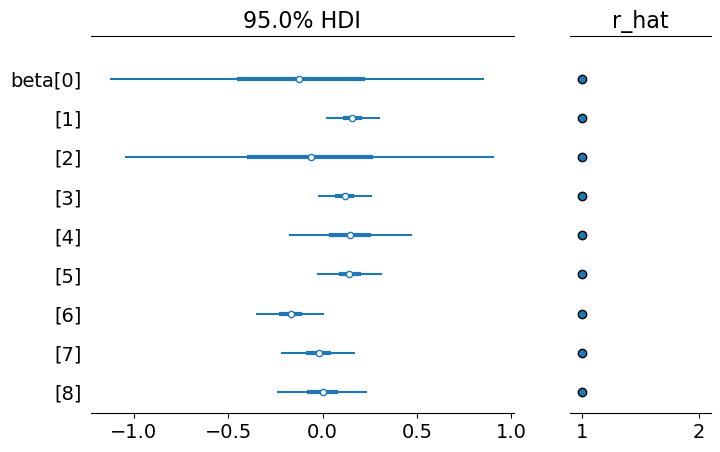

In [27]:
az.plot_forest(idata, var_names=["beta"], combined=True, hdi_prob=0.95, r_hat=True)

### Prediction Accuracy Metrics

#### Mean Absolute Error (MAE)

Measures the average magnitude of the errors in a set of predictions, without considering their direction.

#### Root Mean Squared Error (RMSE) 

Measures the square root of the average of squared differences between predicted and observed values, providing an indication of the model’s overall error.

#### Coverage Probability

The proportion of observed data points that lie within a specified credible interval (e.g., 95% credible interval) of the predicted distribution. High coverage indicates that the model’s uncertainty estimates are reliable.

### Residual Analysis

#### Spatial Residual Plots 

Plot residuals (the differences between observed and predicted values) over the spatial domain to check for patterns. Randomly distributed residuals indicate a good fit.

In [31]:
posterior_predictive

KeyError: 'y_obs_dim_2'

In [28]:
# Extract the observed and simulated data
y_obs = response
y_sim = posterior_predictive['y_obs'].mean(axis=0)  # Mean prediction for each observed data point

# Calculate residuals
residuals = y_obs - y_sim

# Plot spatial residuals
plt.figure(figsize=(12, 8))
sc = plt.scatter(coordinates_observed[:, 0], coordinates_observed[:, 1], c=residuals, cmap='coolwarm', s=100)
plt.colorbar(sc, label='Residuals')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Spatial Residual Plot')
plt.show()

# Histogram of residuals
plt.figure(figsize=(12, 6))
plt.hist(residuals, bins=30, edgecolor='k', alpha=0.7)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()

KeyError: 'y_obs'

### Uncertainty Quantification

	•	Credible Intervals: Evaluate the width of the credible intervals for predictions. Narrower intervals indicate higher precision, but they should still encompass the true values.
	•	Uncertainty Maps: Generate maps of prediction uncertainty to visualize areas of high and low certainty in the predictions.

#### Credible Intervals

Evaluate the width of the credible intervals for predictions. Narrower intervals indicate higher precision, but they should still encompass the true values.

In [ ]:
# Extract the observed and simulated data
y_obs = response

# Generate posterior predictive samples for checks
with model:
    posterior_predictive = pm.sample_posterior_predictive(idata, var_names=['y_obs'], return_inferencedata=True)

# Extract the mean prediction, lower and upper bounds of the 95% credible intervals
y_sim = posterior_predictive.posterior_predictive['y_obs'].mean(dim=("chain", "draw")).values
hdi = az.hdi(posterior_predictive.posterior_predictive, hdi_prob=0.95)['y_obs']

# Calculate the width of the credible intervals
ci_width = hdi[:, 1] - hdi[:, 0]

# Check how many true values are within the credible intervals
within_ci = np.sum((y_obs >= hdi[:, 0]) & (y_obs <= hdi[:, 1]))
total_obs = len(y_obs)
coverage = within_ci / total_obs

print(f"Coverage of 95% Credible Intervals: {coverage * 100:.2f}%")

# Plot the credible intervals vs the observed values
plt.figure(figsize=(12, 8))
plt.errorbar(np.arange(len(y_obs)), y_sim, yerr=[y_sim - hdi[:, 0], hdi[:, 1] - y_sim], fmt='o', label='Predictions with 95% CI')
plt.plot(np.arange(len(y_obs)), y_obs, 'r.', label='Observed Values')
plt.xlabel('Data Point Index')
plt.ylabel('Values')
plt.title('Predictions with 95% Credible Intervals vs Observed Values')
plt.legend()
plt.show()

# Plot the width of the credible intervals
plt.figure(figsize=(12, 6))
plt.hist(ci_width, bins=30, edgecolor='k', alpha=0.7)
plt.xlabel('Width of 95% Credible Intervals')
plt.ylabel('Frequency')
plt.title('Histogram of the Width of 95% Credible Intervals')
plt.show()

#### Credible intervals for predictions

In [ ]:
# Function to generate predictions using posterior samples
def generate_predictions(model, coordinates_new, X_new, idata):
    with model:
        jitter = 1e-5  # Increase the jitter value
        f_pred = gp.conditional('f_pred', coordinates_new, jitter=jitter)
        beta_mean = idata.posterior['beta'].mean(dim=("chain", "draw")).values
        mu_pred = pm.math.dot(X_new, beta_mean) + f_pred
        pred_samples = pm.sample_posterior_predictive(idata, var_names=["f_pred"], return_inferencedata=True)
        return mu_pred, pred_samples

# Generate predictions
mu_pred, pred_samples = generate_predictions(model, coordinates_new, X_new, idata)

In [ ]:
# Extract the samples for the predicted function values
f_pred_samples = pred_samples.posterior_predictive["f_pred"]

# Compute the 95% credible intervals
hdi = az.hdi(f_pred_samples, hdi_prob=0.95)

# Extract mean predictions
mu_pred_mean = f_pred_samples.mean(dim=("chain", "draw")).values

# Extract lower and upper bounds of the credible intervals
ci_lower = hdi.sel(hdi="lower").to_array().values.flatten()
ci_upper = hdi.sel(hdi="higher").to_array().values.flatten()

# Calculate the width of the credible intervals
ci_width = ci_upper - ci_lower

# Plot the credible intervals for new data
plt.figure(figsize=(12, 8))
plt.errorbar(np.arange(len(mu_pred_mean)), mu_pred_mean, yerr=[mu_pred_mean - ci_lower, ci_upper - mu_pred_mean], fmt='o', label='Predictions with 95% CI')
plt.xlabel('Data Point Index')
plt.ylabel('Predicted Values')
plt.title('Predictions with 95% Credible Intervals for New Data')
plt.legend()
plt.show()

# Plot the width of the credible intervals
plt.figure(figsize=(12, 6))
plt.hist(ci_width, bins=30, edgecolor='k', alpha=0.7)
plt.xlabel('Width of 95% Credible Intervals')
plt.ylabel('Frequency')
plt.title('Histogram of the Width of 95% Credible Intervals for New Data')
plt.show()

# Generate uncertainty maps
plt.figure(figsize=(12, 8))
sc = plt.scatter(coordinates_new[:, 0], coordinates_new[:, 1], c=ci_width, cmap='coolwarm', s=100)
plt.colorbar(sc, label='Credible Interval Width')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Prediction Uncertainty Map')
plt.show()

In [ ]:
ci_upper

#### Uncertainty Maps 

Generate maps of prediction uncertainty to visualize areas of high and low certainty in the predictions.

#### Trace plots

Interpretation of Trace Plots

    Density Plots (Left Column):
        Each subplot on the left shows the kernel density estimate of the posterior distribution for a parameter.
        These plots give an idea of the central tendency (mean or median) and the spread (variance) of the parameter estimates.
        For example, the density plot for beta shows multiple colored curves corresponding to different chains, indicating the posterior distributions of the coefficients.

    Trace Plots (Right Column):
        Each subplot on the right shows the sampled values of the parameter across iterations for each chain.
        These plots help in assessing the convergence of the Markov Chain Monte Carlo (MCMC) sampling.
        A good trace plot should look like a "hairy caterpillar," with the chains mixing well and no apparent trends or patterns over iterations.

In [ ]:
import matplotlib.pyplot as plt

# Generate the trace plot
trace_plot = az.plot_trace(idata)

# Save the plot to a file
plt.savefig('temp_files/trace_plot.png')

### Create modeled surface maps

In [ ]:
# Assuming new_coordinates is a grid, reshape mean predictions
x_new = coordinates_new[:, 0].reshape(grid_shape)  # Define grid_shape as per your coordinate grid
y_new = coordinates_new[:, 1].reshape(grid_shape)
z_pred_mean = y_pred_mean.reshape(grid_shape)

# Plot the mean predictions
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x_new, y_new, z_pred_mean, cmap='viridis')

plt.title('Modeled Surface Map')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
ax.set_zlabel('Predicted Value')
plt.show()